In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import sys, os
import pystk
import ray
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device = ', device)
ray.init(logging_level=50, num_cpus=2)

device =  cpu


RayContext(dashboard_url='', python_version='3.9.12', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-05-04_20-44-40_051961_7979/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-05-04_20-44-40_051961_7979/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-05-04_20-44-40_051961_7979', 'metrics_export_port': 56625, 'gcs_address': '127.0.0.1:56417', 'address': '127.0.0.1:56417', 'node_id': 'fc26eae4dfba9048517a0c151e205fb33e66d7c3501bb5db496728b8'})

In [2]:
from state_agent.agents.subnets.actors import SteeringActor, DriftActor, SpeedActor
from state_agent.agents.subnets.planners import PlayerPuckGoalPlannerActor
from state_agent.agents.subnets.agents import Agent, BaseTeam
from state_agent.agents.subnets.utils import Rollout, run_soccer_agent, rollout_many, show_trajectory_histogram, load_model, save_model
from state_agent.agents.subnets.rewards import OpponentDistanceObjective
from state_agent.agents.subnets.features import get_distance_cart_to_puck, OpponentFeatures
from state_agent.trainers.train_policy_gradient import reinforce, SoccerReinforcementConfiguration

import numpy as np
import copy
import matplotlib.pyplot as plt

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (400, 300) to (400, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


/Users/posternutbag/Desktop/2022 Spring/Final Project/DL-Final-Project/notebooks/state_agent/agents/subnets/utils.py:240: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


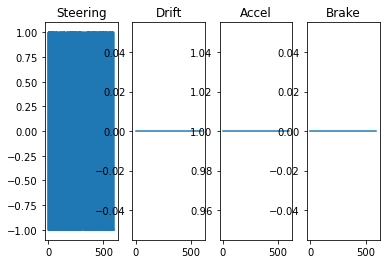

In [3]:
data = run_soccer_agent(Agent(SteeringActor(), train=True))

In [4]:
def get_initializations(actor_class):    
    distance_objective = OpponentDistanceObjective(150)
    many_actors = [actor_class() for i in range(100)]

    data = rollout_many([
        Agent(actor, accel=0.05, extractor=OpponentFeatures()) for actor in many_actors
    ], randomize=True, n_steps=600, num_karts=2, focus='opponent', num_rollout=2)

    good_initialization = many_actors[ np.argmax([distance_objective.calculate_state_score(d[-1]) for d in data]) ]
    bad_initialization = many_actors[ np.argmin([distance_objective.calculate_state_score(d[-1]) for d in data]) ]
    
    return good_initialization, bad_initialization

good_initialization, _ = get_initializations(SteeringActor)

TypeError: state_agent.agents.subnets.agents.BaseAgent.__init__() got multiple values for keyword argument 'extractor'

In [ ]:
data = run_soccer_agent(Agent(SteeringActor(good_initialization.action_net), extractor=OpponentFeatures()), num_karts=2, focus='opponent')

In [ ]:
#good_initialization = best_steering_net
action_net = copy.deepcopy(good_initialization.action_net)
actors = [SteeringActor(action_net)]

def gen_agent(*args, **kwargs):
    return Agent(*args, accel=0.05, target_speed=10.0, **kwargs)

# configuration
config = SoccerReinforcementConfiguration(focus='opponent')
config.agent = gen_agent

# iterations is high relatively here to help force a good outcome from a bad initialization
best_steering_net = reinforce(
    actors[0],
    actors,
    config, 
    n_epochs=5, 
    n_iterations=500, 
    n_trajectories=200, 
    n_validations=100, 
    T=1,
    focus='opponent'
)

In [ ]:
data = run_soccer_agent(Agent(SteeringActor(best_steering_net), accel=0.1, extractor=OpponentFeatures()), num_karts=2, focus='opponent', randomize=True)

In [ ]:
# save the steering actor
save_model(best_steering_net, 'modules/steering/agent_defense.th')

In [ ]:
# load the steering actor
best_steering_net = load_model('modules/steering/agent_defense.th', model=SteeringActor().action_net)

In [ ]:
# train the speed actor
good_initialization_speed, _ = get_initializations(SpeedActor)

action_net = copy.deepcopy(good_initialization_speed.action_net)
actors = [SteeringActor(best_steering_net, train=False), SpeedActor(action_net)]

def gen_agent(*args, **kwargs):
    reverse = np.random.uniform(0, 1) < 0.25
    speed = np.random.uniform(0, 23) * (-1.0 if reverse else 1.0)
    return Agent(*args, target_speed=speed, **kwargs)

# configuration
config = SoccerReinforcementConfiguration(focus='opponent')
config.agent = gen_agent

# iterations is high relatively here to help force a good outcome from a bad initialization
best_speed_net = reinforce(
    actors[1],
    actors,
    config, 
    n_epochs=5, 
    n_iterations=500, 
    n_trajectories=200, 
    n_validations=100, 
    T=1,
    focus='opponent'
)
# best_speed_net = action_net

In [ ]:
data = run_soccer_agent(Agent(SteeringActor(best_steering_net), SpeedActor(best_speed_net), extractor=OpponentFeatures()), num_karts=2, focus='opponent', randomize=True)

In [ ]:
save_model(best_speed_net, 'modules/speed/agent_defense.th')

In [ ]:
# load the speed actor
best_speed_net = load_model('modules/speed/agent_defense.th', model=SpeedActor().action_net)

In [ ]:
# train the player goal scoring planner

def create_planner_actor():
    return PlayerPuckGoalPlannerActor(
        SpeedActor(best_speed_net),
        SteeringActor(best_steering_net)
    )

def gen_agent(*args, **kwargs):
    return Agent(*args, target_speed=5.0, **kwargs)

def rollout_initializer(world_info, randomize, **kwargs):
        
    wall_case = np.random.uniform(low=0.0, high=1.0) < 0.1
    wall_case = True
    
    # generate a rollout where the player and puck are near each other
    position = np.random.uniform(low=-10, high=10, size=(2))
    offset = [np.random.uniform(low=-1.0, high=1.0), -6]    
    world_info.set_ball_location((position[0], 1, position[1]), (0, 0, 0))        
    
    if wall_case:
        player_location = [20 * np.sign(np.random.uniform(-1, 1)), 1, 62]
    else:        
        player_location = [position[0] + offset[0], 1, position[1] + offset[1]]
    world_info.set_kart_location(0, player_location, [0, 0, 0, 1.0], 0)
        
def post_epoch(actor, context):
    # show a histogram of distances
    show_trajectory_histogram(context.trajectories, get_distance_cart_to_puck, max=60, bins=20)
    plt.hist(context.rewards) 
    plt.title("Rewards")
    plt.show()
    plt.hist(context.actions, 3, range=(0, 3)) 
    plt.title("Actions")
    plt.show()
    print(np.sum(np.argmax(context.actions, axis=1) == 0), np.sum(np.argmax(context.actions, axis=1) == 1), np.sum(np.argmax(context.actions, axis=1) == 2))

good_initialization_planner, _ = get_initializations(create_planner_actor)

# Going to need to train this a few times as the convergence is slow!!! Comment this line to retrain 
action_net = copy.deepcopy(good_initialization_planner.action_net)
actors = [PlayerPuckGoalPlannerActor(SpeedActor(best_speed_net), SteeringActor(best_steering_net), action_net)]

# give it a positive random weight to make it the worst case
#action_net.net[0].weight = torch.nn.Parameter(torch.Tensor([[np.random.uniform(0, 1.0)]]))

#starting_weight = action_net.net[0].weight.clone()
#print("Starting weight", action_net.net[0].weight)

# configuration
config = SoccerReinforcementConfiguration(focus='opponent')
config.agent = gen_agent
config.rollout_initializer = rollout_initializer

# iterations is high relatively here to help force a good outcome from a bad initialization
best_planner_net = reinforce(
    actors[0],
    actors,
    config,
    n_epochs=4, 
    n_iterations=1000, 
    n_trajectories=200, 
    n_validations=20, 
    T=1,
    epoch_post_process=post_epoch,
    focus='opponent'
)

#assert(action_net.net[0].weight != starting_weight)


In [ ]:
# case 1 against a wall
#assert(action_net(torch.Tensor([10.255, 0.9, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0]))[0] == 1)
# case 2, travelling to puck
#assert(action_net(torch.Tensor([10.255, 10.255, 10.01, 10.01, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0]))[0] == 2)
# case 3, moving puck
#assert(action_net(torch.Tensor([-1.03, -0.24, 2.0, -0.01, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0]))[0] == 2)



action_net.train()
output = action_net(torch.Tensor([10.255, 0.9, 0.1, 0.1, 0.5, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0]))
output1 = action_net(torch.Tensor([10.255, 0.9, 2.0, 10.1, 10.01, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0]))
output2 = action_net(torch.Tensor([-0.1, -0.1, 2.0, 12.1, 10.01,  1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0]))
action_net.eval()
print(output, output1, output2)




In [ ]:
optim = torch.optim.Adam(action_net.classifiers[2].parameters(), lr=1e-3)
optim.zero_grad()
action_net.classifiers[2].train()
value = action_net.classifiers[2](torch.Tensor([10.255, 0.9, 53.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0]))
print(value)
dist=torch.distributions.Bernoulli(value)
log_prob = dist.log_prob(torch.tensor(1.0))
nll = -log_prob * 10
nll.backward()
optim.step()
print(nll)
print(action_net.classifiers[2].net[0].weight.grad)
action_net_test.classifiers[2].eval()

In [ ]:
best_planner_net = action_net
data = run_soccer_agent(Agent( 
    PlayerPuckGoalPlannerActor(
        speed_net=SpeedActor(best_speed_net),
        steering_net=SteeringActor(best_steering_net), 
        action_net=best_planner_net        
    ), accel=0.1, target_speed=17.0
), randomize=True, player_location=[-20, 1, 62])

In [ ]:
# save the planner actor
save_model(best_planner_net, 'modules/planner/agent_defense.th')

In [ ]:
# load the planner actor
best_planner_net = load_model('modules/planner/agent_defense.th', model=PlayerPuckGoalPlannerActor(best_speed_net, best_steering_net).action_net)

In [ ]:
viz_rollout_soccer = Rollout.remote(400, 300, mode="soccer", players=[(0, False, "tux")], num_karts=1)
data = run_soccer_agent(Agent( 
    PlayerPuckGoalPlannerActor(
        speed_net=SpeedActor(best_speed_net),
        steering_net=SteeringActor(best_steering_net), 
        action_net=best_planner_net        
    )
), rollout=viz_rollout_soccer)

In [ ]:
from state_agent.agents.subnets.action_nets import LinearWithSigmoid, LinearWithTanh
net=LinearWithSigmoid(n_inputs=2, n_hidden=10, n_outputs=1, bias=False)

def log_prob(output, actions):
    dist=torch.distributions.Bernoulli(probs=output)
    return dist.log_prob(actions)

def reward(features):
    
    logits = net(features)
    actions = (logits > 0.5).squeeze().float()
    bools = (features[:,0] < 0) & (features[:,1] < 0)
    #rewards = -features.sum(dim=1) * logits
    #rewards = (actions * 2 - 1)
    rewards = bools.float()
    
    #print(rewards)
    
    return actions.detach(), rewards.detach(), bools.float()

features = np.random.uniform(-1, 1, size=(100, 2))
batch_features = torch.tensor(features).float() # - features.mean(dim=0)
correct_labels = (batch_features[:,0] < 0) & (batch_features[:, 1] < 0)
print(correct_labels)

In [ ]:
def bce_loop(optim, net):
    loss_bce = torch.nn.BCEWithLogitsLoss()
    net.train()
    optim.zero_grad()
    idx = torch.randperm(batch_features.shape[0])
    t_shuffled = batch_features[idx]
    batch_actions, batch_rewards, batch_labels = reward(t_shuffled)
    output = (net(t_shuffled)).squeeze() # + 1) / 2
    #print(output)
    #log_p = log_prob(output, actions=batch_actions)
    #expected_log_return = (log_p.squeeze()*batch_returns).mean()
    loss = loss_bce(output, batch_labels)    
    #(-expected_log_return).backward()
    loss.backward()

    #print("Grad", net.net[0].weight.grad)

    optim.step()
    net.eval()
    return batch_actions

def nll_loop(optim, net, static_reward=True):
    net.train()
    optim.zero_grad()
    idx = torch.randperm(batch_features.shape[0])
    t_shuffled = batch_features[idx]
    batch_actions, batch_rewards, batch_labels = reward(t_shuffled)
    output = (net(t_shuffled)).squeeze() # + 1) / 2
    #print(output)    
    if static_reward:
        log_p = log_prob(output, actions=batch_labels)
        expected_log_return = (log_p.squeeze()*1).mean()
    else:
        log_p = log_prob(output, actions=batch_actions)
        expected_log_return = (log_p.squeeze()*batch_rewards).mean()
    (-expected_log_return).backward()
    #loss.backward()

    #print("Grad", net.net[0].weight.grad)

    optim.step()
    net.eval()
    return batch_actions

    
net=LinearWithSigmoid(n_inputs=2, n_hidden=10, n_outputs=1, bias=True)
optim = torch.optim.Adam(net.parameters(), lr=1e-3)
print("bce (before)", ((net(batch_features) > 0.5).squeeze() == correct_labels).sum())
data = [bce_loop(optim, net) for i in range(10000)]
print("bce", ((net(batch_features) > 0.9).squeeze() == correct_labels).sum())

net=LinearWithSigmoid(n_inputs=2, n_hidden=10, n_outputs=1, bias=True)
optim = torch.optim.Adam(net.parameters(), lr=1e-3)
print("nll (before)", ((net(batch_features) > 0.5).squeeze() == correct_labels).sum())
data = [nll_loop(optim, net, static_reward=True) for i in range(10000)]
print("nll", ((net(batch_features) > 0.9).squeeze() == correct_labels).sum())

net=LinearWithSigmoid(n_inputs=2, n_hidden=10, n_outputs=1, bias=True)
optim = torch.optim.Adam(net.parameters(), lr=1e-3)
print("nll with rewards (before)", ((net(batch_features) > 0.5).squeeze() == correct_labels).sum())
data = [nll_loop(optim, net, static_reward=False) for i in range(10000)]
print("nll with rewards", ((net(batch_features) > 0.9).squeeze() == correct_labels).sum())